# STM Transit Delay Data Modeling

## Overview

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`vehicle_in_transit`: Indicates if the vehicle is in transit or if it has stopped.<br>
`vehicle_rel_distance`: Relative vehicle distance from the previous stop, from 0 (previous stop) to 1 (current stop).<br>
`vehicle_bearing`: Direction that the vehicle is facing.<br>
`vehicle_speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair<br>
`day_of_week`, `hour`: Month, day of week and hour of the realtime arrival time.<br>
`is_weekend`: Indicates if the day of the arrival time is on the weekend.<br>
`is_peak_hour`: Indicates of the day and hour of the arrival time is at peak hour (weekdays between 7-9am and 4-6pm).<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`windspeed`: Wind speed at 10 meters above ground, in km/h.<br>
`weather_Cloudy`, `weather_Drizzle`, `weather_Rain`: Indicates the weather category.<br>
`incident_nearby`: Indicates if an incident happened within 1.5 km of the vehicle position.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.

## Imports

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from xgboost import XGBRegressor

In [15]:
df = pd.read_csv('../data/preprocessed.csv')
df.head()

,vehicle_id,vehicle_in_transit,vehicle_bearing,vehicle_speed,occupancy_status,route_id,stop_id,stop_lat,stop_lon,stop_distance,...,day_of_week,hour,is_weekend,is_peak_hour,weather_Cloudy,weather_Drizzle,weather_Rain,incident_nearby,delay,delay_class
0,745,1,54.0,0.00000,1,34,7436,45.668193,-73.549411,99.375552,...,6,18,1,0,0,0,0,0,0.0,2
1,741,0,54.0,0.00000,2,34,4358,45.616888,-73.615098,457.895119,...,6,18,1,0,0,0,0,0,92.0,2
2,741,1,334.0,11.94454,1,34,7353,45.665987,-73.546685,199.293772,...,6,18,1,0,0,0,0,0,92.0,2
3,696,0,0.0,0.00000,2,48,3212,45.546494,-73.690543,284.130563,...,6,18,1,0,0,0,0,0,374.0,3
4,800,1,269.0,5.00004,2,102,1358,45.495629,-73.601030,188.007922,...,6,18,1,0,0,0,0,0,286.0,3


## Split the data

In [18]:
df = df.drop('delay_class', axis=1)

In [19]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [20]:
# Train-validation-test split (70-15-15) 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## First Model: Random Forest Regression

### Fit Base Model

In [21]:
rf_base = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)

Exception ignored in: <function ResourceTracker.__del__ at 0x10bf2b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10a87f740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

### Evaluate Model

#### Metrics

In [22]:
# Create dataframe to track metrics
metrics_df = pd.DataFrame(columns=['model', 'params', 'MAE', 'RMSE', 'R²'])

In [23]:
def add_metrics(metrics_df:pd.DataFrame, model, y_pred:pd.Series, y_val:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_val, y_pred)
	rmse = root_mean_squared_error(y_val, y_pred)
	r2 = r2_score(y_val, y_pred)

	metrics_df.loc[len(metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]
	return metrics_df

In [24]:
# Calculate metrics
y_pred = rf_base.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_base, y_pred, y_val, 'rf_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,91.062579,142.427921,0.217716


**MAE**<br>
On average, the predictions are off by 72 seconds, which seems acceptable.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 22% of the variance in the actual delays, which is not good, but understandable considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### K-Fold Cross Validation

In [25]:
def get_cv_scores(model, X_train:pd.DataFrame, y_train:pd.Series, k:int=5) -> pd.DataFrame:
	scoring = {
  		'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
  		'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
  		'R²': make_scorer(r2_score, greater_is_better=True)
	}
	cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=k, n_jobs=-1)
	return pd.DataFrame(cv_scores)

In [26]:
cv_scores_df = get_cv_scores(rf_base, X_train, y_train)
cv_scores_df

,fit_time,score_time,test_MAE,test_RMSE,test_R²
0,137.874873,0.628505,-92.627635,-144.284427,0.198698
1,137.345268,0.551661,-92.842297,-144.850750,0.198174
2,137.951183,0.733751,-91.317840,-142.024804,0.209128
3,138.354265,0.455892,-90.807062,-141.084646,0.213605
4,137.251953,0.605528,-91.828783,-142.003305,0.217503


In [27]:
def add_cv_metrics(metrics_df:pd.DataFrame, cv_scores_df:pd.DataFrame, model, model_name:str) -> pd.DataFrame:
	mae = -cv_scores_df['test_MAE'].mean()
	rmse = -cv_scores_df['test_RMSE'].mean()
	r2 = cv_scores_df['test_R²'].mean()
	metrics_df.loc[len(metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]

	return metrics_df

In [28]:
# Add average metrics to dataframe
metrics_df = add_cv_metrics(metrics_df, cv_scores_df, rf_base, 'rf_base_cv')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,91.062579,142.427921,0.217716
1,rf_base_cv,91.884723,142.849586,0.207422


#### Residual Analysis

In [29]:
def plot_residuals(y_pred: pd.Series, y_true:pd.Series, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted delay (seconds)')
	ax1.set_ylabel('Actual delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

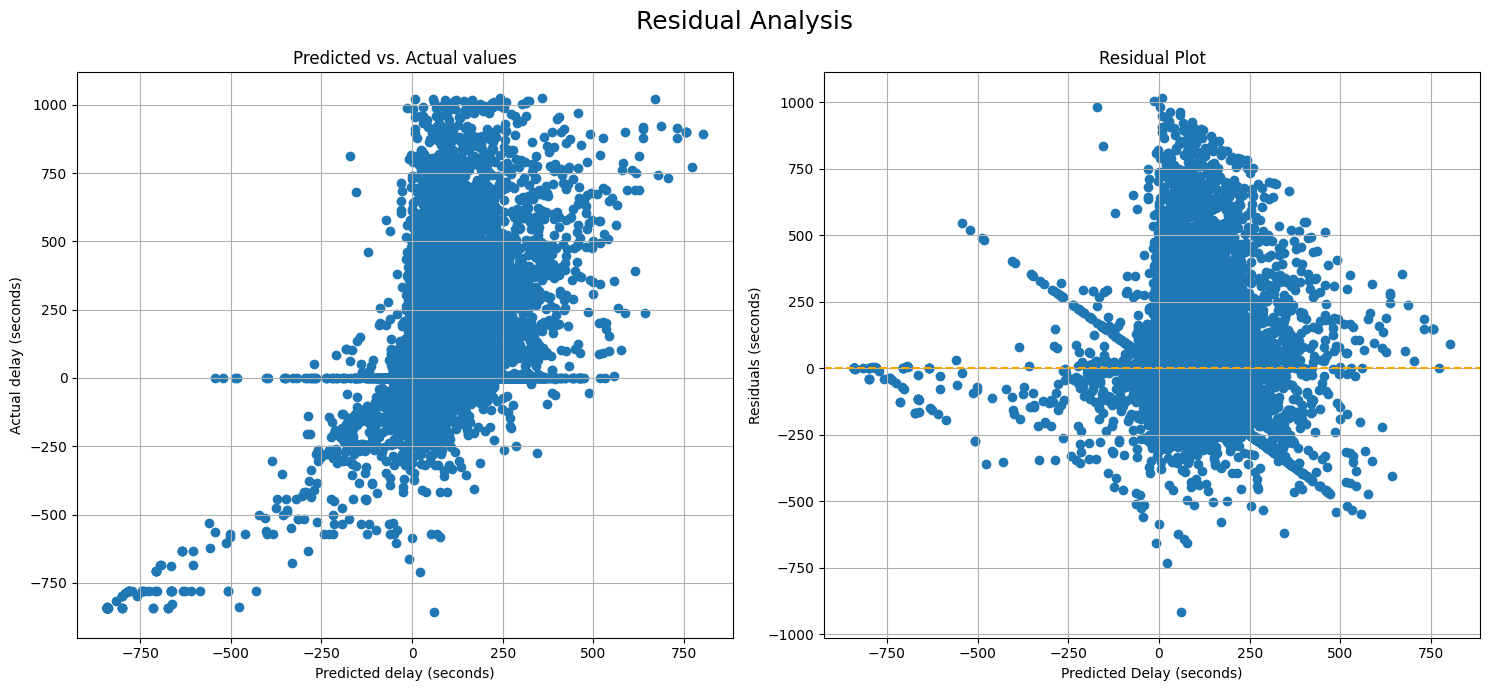

In [30]:
plot_residuals(y_pred, y_val, 'rf_base')

The predicted vs. actual plot shows a scatter of points, with some spread around the diagonal line, which indicates the model's predictions are not perfect but are reasonable. The spread of points suggests the model has a reasonable fit but doesn't handle extreme delays very well.

From the residual plot, it seems that the residuals are fairly spread out, with visible funnel shapes and most of the data clustered around 0, but also a significant spread both above and below the 0 line. This suggests there is no clear pattern in residuals (not biased in one direction). Also, it suggests the residuals appear to increase as the predicted delay increases, meaning the model prediction errors are larger for higher predicted delays (heteroscedasticity). This means the model is better at predicting small delays than large delays.

### Hyperparameter tuning

Due to the large volume of data, the Randomized Search will be run instead of a Grid Search. Also, it will be done manually with early stopping to save computation time, because there's no retraining from scratch each time.

In [31]:
def random_search_rf(X_train, X_val, y_train, y_val, start_rmse:float, nb_combinations:int=10) -> dict:
	n_estimators_range = range(50, 750, 20) 
	max_depth_options = [None, 10, 20]
	max_features_options = ['sqrt', 'log2', 0.8]
	min_samples_split_options = [2, 5, 10]
	min_samples_leaf_options = [1, 2, 5]
	max_leaf_nodes_options = [None, 50, 100]

	best_rmse = start_rmse
	best_params = {}
	result = {}

	# Loop over combinations and number of trees
	for _ in range(nb_combinations):
		max_depth = random.choice(max_depth_options)
		max_features = random.choice(max_features_options)
		min_samples_split = random.choice(min_samples_split_options)
		min_samples_leaf = random.choice(min_samples_leaf_options)
		max_leaf_nodes = random.choice(max_leaf_nodes_options)
		
		rf = RandomForestRegressor(
			warm_start=True,
			n_estimators=50,
			max_depth=max_depth,
			max_features=max_features,
			min_samples_split=min_samples_split,
			min_samples_leaf=min_samples_leaf,
			max_leaf_nodes=max_leaf_nodes,
			random_state=42,
			n_jobs=-1
		)

		errors = []
		
		for n in n_estimators_range:
			rf.n_estimators = n
			params = {
				'n_estimators': rf.n_estimators,
				'max_depth': rf.max_depth,
				'max_features': rf.max_features,
				'min_samples_split': rf.min_samples_split,
				'min_samples_leaf': rf.min_samples_leaf,
				'max_leaf_nodes': rf.max_leaf_nodes
			}

			rf.fit(X_train, y_train)
			preds = rf.predict(X_val)
			rmse = root_mean_squared_error(y_val, preds)
			errors.append(rmse)
			
			if rmse < best_rmse:
				best_rmse = rmse
				best_params = params
				result = {
					'best_rmse': best_rmse,
					'best_params': best_params
				}
	
	return result

In [32]:
# Run random search
start_rmse = float(metrics_df['RMSE'].min())
search = random_search_rf(X_train, X_val, y_train, y_val, start_rmse)

if not search:
	print('No better parameters were found.')
else:
	best_params = search['best_params']
	print(f'Best parameters found: {best_params} with RMSE: {search['best_rmse']:.4f}')	

Exception ignored in: <function ResourceTracker.__del__ at 0x10a733740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10aa07740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

KeyboardInterrupt: 

In [20]:
# Fit model with best parameters
rf_tuned = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
	max_features=best_params['max_features'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=510, n_jobs=-1,
                      random_state=42)

In [21]:
# Calculate metrics
y_pred = rf_tuned.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_tuned, y_pred, y_val, 'rf_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,77.229749,122.803624,0.119041
1,rf_base_cv,78.017720,124.279917,0.100192
2,rf_tuned,75.495374,120.500089,0.151781


In [ ]:
# Cross validate again
cv_scores_df = get_cv_scores(rf_tuned, X_train, y_train)
cv_scores_df

In [ ]:
# Add average metrics to dataframe
metrics_df = add_cv_metrics(metrics_df, cv_scores_df, rf_tuned, 'rf_tuned_cv')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

### Feature Importances

In [22]:
rf_tuned = rf_base
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [23]:
# Sort predictors
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

trip_id                 0.118878
trip_progress           0.117180
vehicle_id              0.097130
vehicle_rel_distance    0.077212
stop_lon                0.074777
stop_lat                0.074649
stop_id                 0.069683
vehicle_bearing         0.063972
route_id                0.057008
windspeed               0.045825
temperature             0.044870
hour                    0.042994
vehicle_speed           0.040713
day_of_week             0.018362
occupancy_status        0.018210
incident_nearby         0.007637
is_peak_hour            0.006544
precipitation           0.006416
weather_Cloudy          0.006159
vehicle_in_transit      0.003688
wheelchair_boarding     0.003477
weather_Drizzle         0.003096
weather_Rain            0.001228
is_weekend              0.000292
dtype: float64

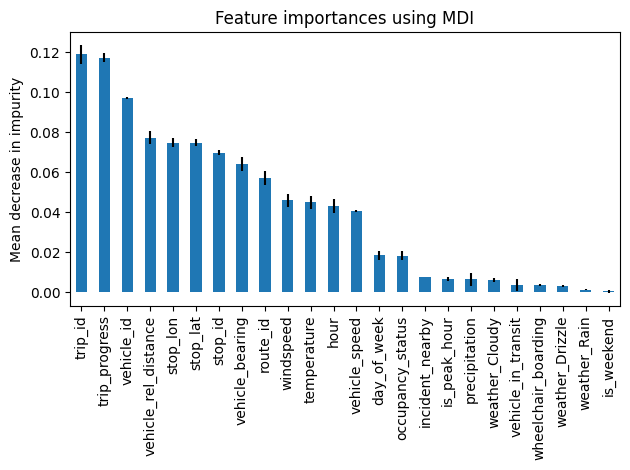

In [24]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

### Recursive Feature Elimination (RFE)

In [25]:
rfe_list = []
X_current = X.copy()
X_train_current = X_train.copy()
X_val_current = X_val.copy()
best_rmse = float(metrics_df['RMSE'].min())
best_features = X_train_current.columns.tolist()
patience = 2 # allow 2 RMSE increases before stopping
patience_counter = 0 

keep_going = True

while keep_going and len(X_current.columns) > 5: # keep at least 5 features
	# Fit model
	rf = RandomForestRegressor(
		n_estimators=best_params['n_estimators'],
		min_samples_split=best_params['min_samples_split'],
  		min_samples_leaf=best_params['min_samples_leaf'],
  		max_leaf_nodes=best_params['max_leaf_nodes'],
  		max_depth=best_params['max_depth'],
  		max_features=best_params['max_features'],
		random_state=42,
		n_jobs=-1
	)

	nb_features = len(X_current.columns)
	rf.fit(X_train_current, y_train)

	# Predict and calculate RMSE
	y_pred = rf.predict(X_val_current)
	rmse = root_mean_squared_error(y_val, y_pred)

	rfe = {
		'nb_features': nb_features,
		'rmse': rmse
	}

	# Feature importances
	importances = pd.Series(rf.feature_importances_, index=X_current.columns)
	weakest_feature = importances.idxmin()

	if rmse <= best_rmse:
		best_rmse = rmse
		best_features = X_current.columns.tolist()
		
		# Drop the weakest feature
		print(f'RMSE: {rmse:.4f} | Dropping: {weakest_feature} (importance {importances.min():.6f})')
		X_current = X_current.drop(columns=[weakest_feature], axis=1)
		X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
		X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)

		patience_counter = 0 # reset patience is RMSE improves
		rfe['worsened_point'] = False
		rfe_list.append(rfe)
	else:
		patience_counter += 1
		rfe['worsened_point'] = True
		rfe_list.append(rfe)
		print(f'Patience counter: {patience_counter}/{patience}')

		if patience_counter >= patience:
			print('Performance worsened too much. Stopping feature elimination.')
			keep_going = False
		else:
			# Allow two bad steps: still drop feature and continue
			X_current = X_current.drop(columns=[weakest_feature], axis=1)
			X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
			X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)


rfe_df = pd.DataFrame(rfe_list)

if len(X_current.columns) < len(X.columns):
	print('\nBest set of features found:')
	print('\n'.join(best_features))
	print(f'Final validation RMSE: {best_rmse:.4f}')
else:
	print('The features remain the same.')

RMSE: 120.5001 | Dropping: is_weekend (importance 0.000341)
Patience counter: 1/2
RMSE: 120.3500 | Dropping: weather_Drizzle (importance 0.002055)
RMSE: 120.3282 | Dropping: wheelchair_boarding (importance 0.002112)
RMSE: 120.1677 | Dropping: incident_nearby (importance 0.005076)
RMSE: 120.1308 | Dropping: vehicle_in_transit (importance 0.004899)
RMSE: 120.0574 | Dropping: precipitation (importance 0.005271)
RMSE: 119.9263 | Dropping: weather_Cloudy (importance 0.007518)
RMSE: 119.8086 | Dropping: is_peak_hour (importance 0.008793)
Patience counter: 1/2
Patience counter: 2/2
Performance worsened too much. Stopping feature elimination.

Best set of features found:
trip_id
vehicle_id
vehicle_rel_distance
vehicle_bearing
vehicle_speed
occupancy_status
route_id
stop_id
stop_lat
stop_lon
trip_progress
day_of_week
hour
is_peak_hour
temperature
windspeed
Final validation RMSE: 119.8086


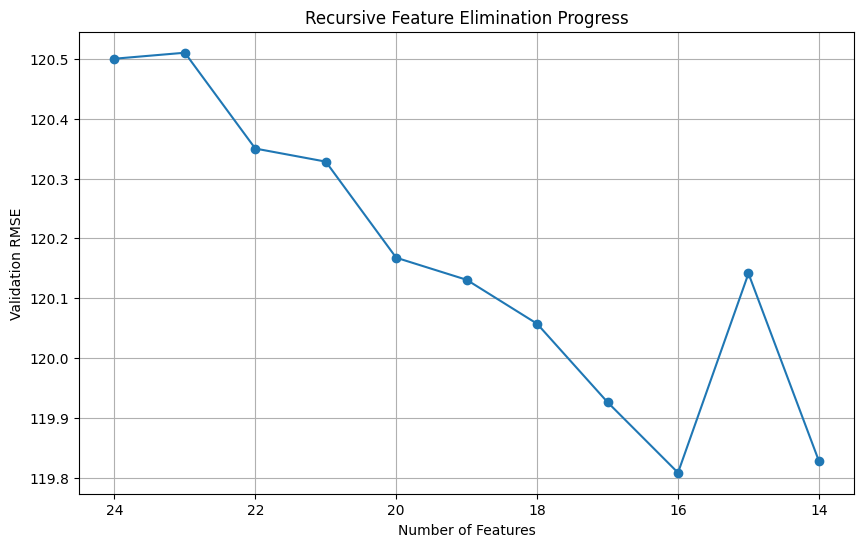

In [26]:
# Plot RSME at each step
plt.figure(figsize=(10,6))
plt.plot(rfe_df['nb_features'], rfe_df['rmse'], marker='o')
plt.gca().invert_xaxis() # Highest number of features on the left
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.title('Recursive Feature Elimination Progress')
plt.grid(True)
plt.savefig('../images/rfe_rf_tuned.png', bbox_inches='tight')
plt.show()

In [27]:
# Keep best features
X_best = X[best_features]
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]

In [28]:
# Retrain model on reduced features
rf_retrained = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_retrained.fit(X_train_best, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=510, n_jobs=-1,
                      random_state=42)

In [29]:
# Evaluate model
y_pred = rf_retrained.predict(X_val_best)

metrics_df = add_metrics(metrics_df, rf_retrained, y_pred, y_val, 'rf_retrained')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,77.229749,122.803624,0.119041
1,rf_base_cv,78.017720,124.279917,0.100192
2,rf_tuned,75.495374,120.500089,0.151781
3,rf_retrained,74.729594,119.808565,0.161489


### Retune Parameters

In [31]:
# Random search
start_rmse = float(metrics_df['RMSE'].min())
search = random_search_rf(X_train_best, X_val_best, y_train, y_val, start_rmse, 5)

if not search:
	print('No better parameters were found.')
else:
	best_params = search['best_params']
	print(f'Best parameters found: {best_params} with RMSE: {search['best_rmse']:.4f}')	

No better parameters were found.


### Revalidate Model

Interpret results

In [ ]:
plot_residuals(y_pred, y_val, 'rf_final')

The plots didn't change much.

Interpret plot

In [32]:
# Display best model
metrics_df.loc[metrics_df['RMSE'].idxmin(), ['model', 'MAE', 'RMSE', 'R²']]

model    rf_retrained
MAE         74.729594
RMSE       119.808565
R²           0.161489
Name: 3, dtype: object

In [33]:
# Save best parameters and features
rf_attributes = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_attributes.pkl', 'wb') as handle:
	pickle.dump(rf_attributes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
rf_final = rf_retrained

In [36]:
# Save model
joblib.dump(rf_final, '../models/rf_model.pkl')

['../models/rf_model.pkl']

## Second Model: Random Forest + Gradient Boosting (Model ensembling)

### Fit Base Model

In [ ]:
# Initialize Random Forest (with best parameters of final rf model) and Gradient Boosting models
rf = RandomForestRegressor(
 	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
  	n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [ ]:
# Define the ensemble model (VotingRegressor)
ensemble_base = VotingRegressor(estimators=[('rf', rf), ('gb', gb)])

In [ ]:
# Fit the model
ensemble_base.fit(X_train, y_train)

### Evaluate Model

In [ ]:
y_pred = ensemble_base.predict(X_val)

metrics_df = add_metrics(metrics_df, ensemble_base, y_pred, y_val, 'ensemble_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE:**

The MAE has slightly increased compared to the previous model (69.63), indicating a small decrease in the accuracy of the ensemble model's predictions.

**RMSE:**

The RMSE has also increased compared to the previous model (116.54), which suggests that the ensemble might still be struggling with larger prediction errors, particularly for extreme delays.

**R²**

The R-squared value has dropped slightly from 0.263 to 0.247. This indicates that the ensemble model explains even less of the variance in the target variable than the previous model.

**Interpretation**
The ensemble approach combining Random Forest and Gradient Boosting has not resulted in a significant improvement over the base model, and the metrics have worsened slightly.

## Third Model: XGBoost

### Fit Base Model

In [37]:
# Initialize the XGBoost model with default parameters
xg_base = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [38]:
# Train a model
xg_base.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Evaluate model

In [39]:
y_pred = xg_base.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_base, y_pred, y_val, 'xg_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,77.229749,122.803624,0.119041
1,rf_base_cv,78.017720,124.279917,0.100192
2,rf_tuned,75.495374,120.500089,0.151781
3,rf_retrained,74.729594,119.808565,0.161489
4,xg_base,75.327906,119.611329,0.164247


**MAE:**

This is a significant improvement over the previous models. The model is now, on average, 65.8 seconds off in its predictions, which is a reduction from the previous 69.6 seconds with the Random Forest and Gradient Boosting models.

**RMSE:**

The RMSE has also decreased compared to the previous ensemble model (117.83), indicating that the XGBoost model is performing better and has reduced the impact of large errors.

**R²:**

This is a substantial improvement from 0.247 (with the ensemble model). With an R-squared of 0,318%, the XGBoost model explains more variance in the data, which shows that it's capturing more of the underlying patterns than the previous models.

**Interpretation**

XGBoost is performing better than the previous models (Random Forest and Gradient Boosting ensemble), particularly in terms of MAE and RMSE. The higher R-squared value also suggests that the model is now explaining more of the variance in the target variable.

### Hyperparameter tuning

In [40]:
# Create a GridSearchCV object
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
				estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
				param_grid=param_grid,
				cv=3,
				verbose=1,
				n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             verbose=1)

In [41]:
# Best parameters found
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [42]:
# Use the best model
xg_tuned = grid_search.best_estimator_

In [45]:
# Evaluate the best model
y_pred = xg_tuned.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_tuned, y_pred, y_val, 'xg_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,77.229749,122.803624,0.119041
1,rf_base_cv,78.017720,124.279917,0.100192
2,rf_tuned,75.495374,120.500089,0.151781
3,rf_retrained,74.729594,119.808565,0.161489
4,xg_base,75.327906,119.611329,0.164247
5,xg_tuned,74.183464,118.591662,0.178436


**MAE:**

This is a small improvement over the previous MAE of 65.77 seconds. The model is now, on average, 64.2 seconds off in its predictions, which is a good step forward.

**RMSE:**

The RMSE has decreased again, from 112.11 to 110.89 seconds, indicating that the model has become slightly more accurate, especially in handling larger errors.

**R²:**

The R-squared value has increased marginally from 0.318 to 0.322, suggesting that the model is now explaining a bit more of the variance in the data, which is an improvement.

## Final Model

### Evaluation

### Make Prediction

## End